In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from tqdm import tqdm 
import datetime

In [3]:
factor_path = "/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/factor/"

futureCodeList = ['JBF', 'QWF', 'HCF', 'DBF', 'EHF', 'IPF', 'IIF', 'QXF', 'PEF', 'NAF']
stockCodeList = ['3443', '2388', '2498', '2610', '1319', '3035', '3006', '2615', '5425', '3105']

data_clean_path = '/Users/shezihua/Documents/MAFM/2022-2023 Summer/MAFS 6100L/SummerIndependentProject/dataCleaned/'

In [4]:
futureCode = futureCodeList[0]
stockCode = stockCodeList[0]

In [5]:
stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

In [6]:
pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

In [7]:
trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

In [37]:
day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])


for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 4:
            # generate delay
            delay_idx = np.random.rand()
            delay = 0
            if delay_idx < np.sin(np.pi/8*3):
                pass
            else: 
                delay = 2

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 30/30 [02:31<00:00,  5.05s/it]


In [38]:
PnL

array([     0,   1000,   1500,   2500,   3000, 119000, 119000,   5000,
         6000,   6500,   7000,   7500,   8500,   9500,  10000,  11000,
       124000,  13500,  14500,  15500,  16000,  17000,  17500,  18500,
       132500,  20000,  21000,  22000,  22500,  23000,  24000,  25000,
        26500,  27000,  27000,  27500, 149500,  29000,  29500,  30500,
       152500,  32000,  32500,  33000,  33000,  32000,  33000,  33500,
        32500,  34000,  34000,  35000,  36000,  37500,  38500,  39500,
        41500,  42000,  43500,  45000,  47000,  48500,  49500,  50500,
        51000,  50500,  51500,  52500,  53000,  53500,  53500,  53500,
        54000,  55500,  55000,  56000,  56500,  56500,  57000,  58500,
        59000,  59000, 206500,  60000,  61000,  61000, 211000,  62500,
        63000,  64500,  66000,  66500,  67000,  68000,  69000,  69000,
       213000, 213000,  71000,  72000,  73000,  74500,  75500,  75500,
        76500,  77500,  78000,  78500,  78000,  78500,  79000,  79000,
      

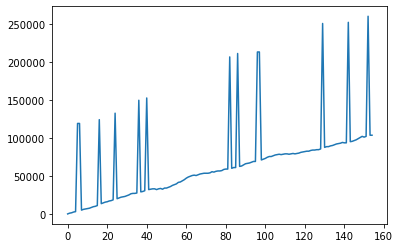

In [39]:
plt.plot(PnL)

# Try on other pairs

In [49]:
futureCode = futureCodeList[1]
stockCode = stockCodeList[1]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 3:
            # generate delay
            delay_idx = np.random.rand()
            delay = 0
            if delay_idx < np.sin(np.pi/8*3):
                pass
            else: 
                delay = 1

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

100%|██████████| 10/10 [00:31<00:00,  3.19s/it]


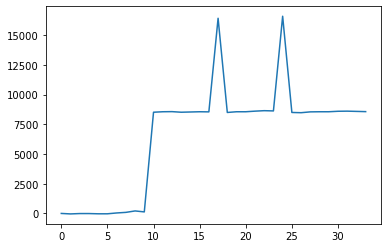

In [50]:
plt.plot(PnL)

100%|██████████| 30/30 [01:07<00:00,  2.26s/it]


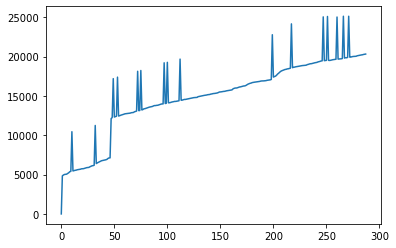

In [51]:
futureCode = futureCodeList[4]
stockCode = stockCodeList[4]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 3:
            # generate delay
            delay_idx = np.random.rand()
            delay = 0
            if delay_idx < np.sin(np.pi/8*3):
                pass
            else: 
                delay = 1

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

plt.plot(PnL)

pair 3

100%|██████████| 30/30 [01:51<00:00,  3.73s/it]


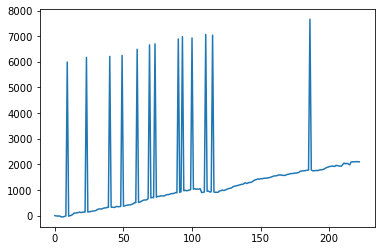

In [54]:
futureCode = futureCodeList[2]
stockCode = stockCodeList[2]

stock = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/stock.csv.gz", compression='gzip', index_col=0)
future = pd.read_csv(data_clean_path + futureCode + "-" + stockCode + "/future.csv.gz", compression='gzip', index_col=0)
spread = np.log(stock['price']) - np.log(future['midQ'])
spread = pd.DataFrame(spread)
spread.columns = ['spread']

pool = pd.DataFrame()
pool.index = stock.index
pool['SP1'] = stock['SP1']
pool['BP1'] = stock['BP1']
pool['askPrice1'] = future['askPrice1']
pool['bidPrice1'] = future['bidPrice1']
pool['spread'] = spread['spread']
pool.index = pd.to_datetime(pool.index)

trade = pd.DataFrame()
trade.index = pool.index
trade['spread'] = pool['spread']
trade['signal'] = 0
trade['cap'] = 0
trade['pnl'] = 0
trade.index = pd.to_datetime(trade.index)

day_list = np.unique(pool.index.date)
train_period = 3
PnL = np.array([0])

for i in tqdm(range(len(day_list) - train_period)[-30:]):
    train_start_time = trade.index >= pd.to_datetime(str(day_list[i]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period - 1]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    train = trade[train_start_time & train_end_time]
    test_start_time = trade.index >= pd.to_datetime(str(day_list[i + train_period]) + ' 09:00:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test_end_time = trade.index <= pd.to_datetime(str(day_list[i + train_period]) + ' 13:30:00.000', format = '%Y/%m/%d %H:%M:%S.%f')
    test = trade[test_start_time & test_end_time]

    current_pool = pool[test_start_time & test_end_time]

    mean = np.mean(train['spread'])
    std = np.std(train['spread'])

    upper = mean + 1.5 * std
    lower = mean - 1.5 * std

    for tick_idx in (range(len(test.index))): 
        current_data = test[0:tick_idx + 1]

        if tick_idx != len(test.index) - 3:
            # generate delay
            delay_idx = np.random.rand()
            delay = 0
            if delay_idx < np.sin(np.pi/8*3):
                pass
            else: 
                delay = 1

            # long spread
            if test.loc[test.index[tick_idx]]['spread'] <= lower: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']

            # back to mean
            elif test.loc[test.index[tick_idx]]['spread'] >= mean: 
                if np.sum(current_data['signal']) == 1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']

            # short spread
            elif test.loc[test.index[tick_idx]]['spread'] >= upper: 
                if np.sum(current_data['signal']) == 0: 
                    test.at[test.index[tick_idx+delay], 'signal'] = -1
                    test.at[test.index[tick_idx+delay], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']

            # back to mean 
            elif test.loc[test.index[tick_idx]]['spread'] <= mean: 
                if np.sum(current_data['signal']) == -1: 
                    test.at[test.index[tick_idx+delay], 'signal'] = 1
                    test.at[test.index[tick_idx+delay], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                    test.at[test.index[tick_idx+delay], 'pnl'] = np.sum(current_data['cap'])# + trade.loc[test.index[tick_idx]]['cap']

            else: 
                pass
        
        else:
            pass
            if np.sum(current_data['signal']) == 1: 
                test.at[test.index[tick_idx], 'signal'] = -1
                test.at[test.index[tick_idx], 'cap'] = - current_pool.iloc[tick_idx]['BP1'] * 2 + current_pool.iloc[tick_idx]['askPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            elif np.sum(current_data['signal']) == -1: 
                test.at[test.index[tick_idx], 'signal'] = 1
                test.at[test.index[tick_idx], 'cap'] = current_pool.iloc[tick_idx]['SP1'] * 2 - current_pool.iloc[tick_idx]['bidPrice1']
                test.at[test.index[tick_idx], 'pnl'] = np.sum(current_data['cap']) #+ trade.loc[test.index[tick_idx]]['cap']
            else:
                pass
    
    
    PnL = np.append(PnL, test[test['pnl'] != 0]['pnl'] + PnL[-1])

plt.plot(PnL)